# Generting OME-TIFFs with tifffile memmap

In [1]:
import os
import pandas as pd
import numpy as np
import argparse
import time
from datetime import timedelta
import mahotas as mh
from tifffile import imsave, TiffWriter, imwrite, memmap, imread

In [2]:
FINFO = '/mnt/monica/quaranta2/Monica/HTS031_partial/HTS031_partial_imageFileInfo.csv'
RED_CH = 'Cy3'
GREEN_CH = 'FITC'
IMG_DIR = '/data/DSA/HTS031_partial'
SAVE_DIR = '/data/DSA/HTS031_partial_ome'

In [3]:
def assemble_plate(img_list):
    for i in range(0, len(img_list), 22):
        # read in one row of images as np arrays
        # Full plate
        row_imgs = np.array([mh.imread(f) for f in img_list[i:i+22]],np.uint16)
        # left side
        # row_imgs = np.array([mh.imread(f) for f in img_list[i:i+11]],np.uint16)
        # right side
        # row_imgs = np.array([mh.imread(f) for f in img_list[i+11:i+22]],np.uint16)
        
        # concatentate the row of images
        for j in range(len(row_imgs)-1):
            if j == 0:
                img1 = row_imgs[j].copy()
                img2 = row_imgs[j+1].copy()
                row = np.concatenate((img1, img2), axis=1)
            else:
                img2 = row_imgs[j+1].copy()
                row = np.concatenate((row, img2), axis=1)
        # stack the rows to form the full plate of images        
        if i == 0:
            plate = row.copy()
        else:
            plate = np.concatenate((plate, row), axis=0)
        
    return plate

In [4]:
def get_filenames(df, img_dir, plate_id):
    df = df.reset_index(drop=True)
    df_sort = df.sort_values(by=['well', 'file_name'], ignore_index=True)
    img_list = []
    filenames = df_sort['file_name'].to_list()
    
    for f in filenames:
        # TEMP FOR TESTING
        # img_list.append(os.path.join(img_dir, f))
        img_list.append(os.path.join(img_dir, 'Plate' + str(plate_id), f))
        
    return img_list

In [9]:
def assemble_stack(finfo, red_ch, green_ch, img_dir, save_dir):
    plates = pd.unique(finfo['plate_name'])
    
    for plate in plates:
        print("Starting ", plate, "assembly..")
        df = finfo[finfo['plate_name']==plate]
        pids = pd.unique(df['plate_id'])
        first = True
        
        fname = f'{SAVE_DIR}/{plate}.tif'
        # full plate
        shape = (13, 1, 2, 30240, 47520)
        # half plate
        # shape = (13, 1, 2, 30240, 23760)
        dtype = 'uint16'
        
        # create empty OME-TIFF file
        imwrite(fname, shape=shape, dtype=dtype, metadata={'axes': 'TZCYX'})
        
        # memory map numoy array to data in OME-TIFF file
        tzcyx_stack = memmap(fname)
        
        i = 0
        te = time.time()
        for pid in pids:
            df2 = df[df['plate_id']==pid]
            ch1_imgs = get_filenames(df2[df2['channel']==red_ch], img_dir, pid)
            ta = time.time()
            ch1_img = assemble_plate(ch1_imgs)
            # tb = time.time()
            # print("Time to complete ch1: ", str(timedelta(seconds=tb-ta)))
            ch2_imgs = get_filenames(df2[df2['channel']==green_ch], img_dir, pid)
            # tc = time.time()
            ch2_img = assemble_plate(ch2_imgs)
            td = time.time()
            # print("Time to complete ch2: ", str(timedelta(seconds=td-tc)))

            tzcyx_stack[i, 0, 0] = ch1_img
            tzcyx_stack[i, 0, 1] = ch2_img
            tzcyx_stack.flush()
            i = i+1
        
        th = time.time()
        print(f"Saved {plate}.tif in {save_dir}")
        print("Time to assemble plate OME tiff: ", str(timedelta(seconds=th-te)))

In [10]:
t1 = time.time()
file_info = pd.read_csv(FINFO, low_memory=False)
assemble_stack(file_info, RED_CH, GREEN_CH, IMG_DIR, SAVE_DIR)
t2 = time.time()
print("Time to complete all plates: ", str(timedelta(seconds=t2-t1)))

Starting  H1048-1 assembly..
Saved H1048-1.tif in /data/DSA/HTS031_partial_ome
Time to assemble plate OME tiff:  0:11:50.726772
Starting  H841-1 assembly..
Saved H841-1.tif in /data/DSA/HTS031_partial_ome
Time to assemble plate OME tiff:  0:12:24.016497
Time to complete all plates:  0:24:16.491737


In [20]:
bigim = imread('/data/DSA/temp/H1048-1_right_memmap.ome.tif')

In [21]:
bigim.shape

(13, 2, 30240, 23760)

In [14]:
# testing aics image read
from aicsimageio import AICSImage
start = time.time()
im =  AICSImage('/data/DSA/temp/H1048-1_right_memmap.ome.tif')
end = time.time()
print("Time to create object: ", str(timedelta(seconds=end-start)))

Time to create object:  0:00:00.016400


In [15]:
print(im.dims)  # returns a Dimensions object
print(im.dims.order)  # returns string "TCZYX"

<Dimensions [T: 13, C: 2, Z: 1, Y: 30240, X: 23760]>
TCZYX


In [16]:
# Try to show only 1 channel at timepoint 2 (index1)
start = time.time()
time1 = im.get_image_data("CZYX", T=1)
end = time.time()
print("Time to read image data: ", str(timedelta(seconds=end-start)))

Time to read image data:  0:04:46.961492


Time to display image data:  0:00:18.504678


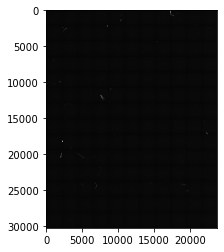

In [20]:
import matplotlib.pyplot as plt

start = time.time()
plt.imshow(time1[0][0], cmap="gray")
end = time.time()
print("Time to display image data ~ ", str(timedelta(seconds=end-start)))